# UM-Bridge with QMCPy

Using QMCPy to evaluate the [UM-Bridge Cantilever Beam Function](https://um-bridge-benchmarks.readthedocs.io/en/docs/forward-benchmarks/muq-beam-propagation.html) and approximate the expectation with respect to a uniform random variable. 

## Imports

In [1]:
import umbridge
import numpy as np
import time
#import docker

#the module needs to be local if any changes have been made locally
#uncomment line below to make local qmcpy the import (only need to be done once per session and can be commented out
#import sys
#sys.path.insert(0, '../../../../..') #may need to be changed to find correct path to QMCSoftware folder

#prints paths available on local system
#for p in sys.path:
#    print(p)

import qmcpy as qp #non local module import
#from QMCSoftware import qmcpy as qp #local module import

## Start Docker Container

See the [UM-Bridge Documentation](https://um-bridge-benchmarks.readthedocs.io/en/docs/index.html) for image options. 

In [35]:
!docker rm -f muqbp_new
!docker run --name muqbp_new -it -d -p 4242:4242 linusseelinger/model-muq-beam:latest
#!docker run --name muqbp_new -d -p 4242:4242 my-build
#https://stackoverflow.com/questions/43099116/error-the-input-device-is-not-a-tty
#running locally

^C
^C


## Problem Setup

Initialize a QMCPy sampler and distribution.

In [39]:
sampler_d = 9
sampler = qp.Lattice(dimension = sampler_d,seed=7) # DISCRETE DISTRIBUTION, default = 3
distribution = qp.Uniform(sampler,lower_bound=1,upper_bound=1.2) # TRUE MEASURE

Initialize a UM-Bridge model and wrap it into a QMCPy compatible Integrand

In [50]:
model = umbridge.HTTPModel('http://localhost:4242', 'forward')
output_dimension = 31 #can't find where 31 is in um-bridge so I'm setting it here
beam_length = 1
umbridge_config = {}
"""DEBUG
print(umbridge_config)
print(model.get_input_sizes(umbridge_config))
print(model.get_output_sizes(umbridge_config))
print(distribution.d)
"""

import math
from sklearn import gaussian_process as gp
kernel = gp.kernels.Matern(length_scale = 0.5, nu=2.5)
#nu controls smoothness, most efficient when in [0.5, 1.5, 2.5, inf]
#0.5 = absolute exponential, 1.5 = once differentiable, 2.5 = twice, ~inf = RBF
#length_scale controls "peakiness"/frequency, or correlation between points farther from each other

def lump(t):
    """ Model 1: fill with ones """
    tnp = np.array(t[0])
    tnewnp = np.ones(output_dimension)
    tnewnp[:len(tnp)] = tnp
    #print(tnewnp.tolist())
    return [tnewnp.tolist()]

def lump_2(t):
    """ Model 2: duplicating values """
    tnp = np.array(t[0])
    tnewnp = np.ones(output_dimension)
    if len(tnp) < output_dimension:
        root = output_dimension // len(tnp)
        for i in range(root + output_dimension % len(tnp)):
            tnewnp[i] = tnp[0]
        #len(tnp) * root + output_dimension % len(tnp) = len(tnp)
        for j in range(1, len(tnp)):
            for i in range(j * root + output_dimension % len(tnp), (j+1) * root + output_dimension % len(tnp)):
                tnewnp[i] = tnp[j]
    #print(tnewnp.tolist())
    return [tnewnp.tolist()]

E_variance = 0.01
x_values = np.arange(float(output_dimension)) * beam_length/float(output_dimension - 1)
def E_generator(*args):
    """Model 3: approximating/smushing continuous by returning distribution w/ multivariate, 
    Gaussian and Matern kernel
    
    Return:
        distribution: a multivariate Gaussian distribution for output_dimension samples
        sampler_out: a new version of sampler with 31 dimensions"""
    tnp = np.array([x_values]).T
    #print(tnp)
    covariances = kernel.__call__(tnp) #takes array of size (# samples) x (# data points)
    #print(covariances)
    average = np.full(output_dimension, (distribution.upper_bound + distribution.lower_bound) / 2)
    #print(average)
    sampler_out = sampler.spawn(1, [output_dimension])[0] #new version of sampler with 31 dimensions
    return qp.Gaussian(sampler_out, average, E_variance * covariances, decomp_type = 'PCA'), sampler_out

weight_decay = 5
wiggly_ness = 0.1 #not sure if this is the constant that I want
def E_generator_2(t, weight_decay = 5, wiggly_ness = 0.1, output_dimension = 31):
    """
    Model 4: Karhunen-Loeve approximation using Chebyshev polynomials
    
    Args:
        t: n x d_i (input dimension) array of samples
    Return:
        tnewnp: n x d_o (output dimension) array of samples"""
    tnp = np.array(t[0])
    tnewnp = np.zeros(output_dimension) #Y(t) = (X_1 ... X_d) W (\phi_1(t) ... \phi_d(t))^T
    d = sampler_d #input dimension
    X = tnp #d samples, uniform iid from "distribution"
    W = np.zeros((d, d))
    for i in range(d):
        W[i][i] = wiggly_ness / ((i+1) ** weight_decay)

    for j in range(output_dimension): #t = x_values[j]
        phi = np.zeros(d)
        for i in range(1, d+1):
            #ax+b where a = 2/(u-l), b = 1 - 2u/(u-l)
            #print(2 * x_values[j] - 1)
            phi[i-1] = math.cos(i * math.acos(2 * x_values[j] - 1)) #Chebyshev polynomials from [0, 1]
        phi = np.array([phi]).T #transpose
        tnewnp[j] = np.matmul(np.matmul(X, W), phi)
        tnewnp[j] += (distribution.lower_bound + distribution.upper_bound) / 2
    #print(tnewnp.tolist())
    #print(sum(tnewnp)/len(tnewnp))
    return [tnewnp.tolist()]

def default(t): 
    """For testing analytical model with constant modulus"""
    return [np.full(output_dimension, (distribution.upper_bound + distribution.lower_bound) / 2).tolist()]
    
#distribution_mul, sampler = E_generator() 
# ^ comment out if you don't want multivariate w/ Matern covariance (and set tf_input_to_umbridge_input = identity)
#integrand = qp.UMBridgeWrapper(distribution_mul, model, umbridge_config, parallel=False, tf_input_to_umbridge_input = lambda t: t) # INTEGRAND
integrand = qp.UMBridgeWrapper(distribution, model, umbridge_config, parallel=False, tf_input_to_umbridge_input = E_generator_2) # INTEGRAND

In [51]:
 #debug
from sklearn import datasets as ds
"""
X, y = ds.load_iris(return_X_y=True)
print(X)
print(y)
kernel.__call__(X)
"""
#kernel.__call__([[1.05], [1.02], [1.06], [1.04]])
#E_generator([np.arange(31.0) * beam_length/31.0])
#distribution.gen_samples(1)[0]
#np.matmul([3, 2, 4], [[1], [2], [1]])
E_generator_2([np.random.rand(9) * (distribution.upper_bound - distribution.lower_bound) + distribution.lower_bound])[0]

[0.9930534870356988,
 0.9996905963479528,
 1.006361770277187,
 1.0130701676515668,
 1.0198168874580802,
 1.0266023083751326,
 1.0334268059937457,
 1.040291053855695,
 1.0471960705594592,
 1.0541431359393267,
 1.061133664709442,
 1.0681690959829462,
 1.0752508317267053,
 1.0823802364943953,
 1.089558694694949,
 1.0967877101995482,
 1.104069026268486,
 1.1114047415892938,
 1.1187974006595784,
 1.1262500438219853,
 1.1337662139646503,
 1.141349933238377,
 1.149005684111626,
 1.1567384546861794,
 1.164553938430082,
 1.1724590133501598,
 1.1804626651240375,
 1.1885775628411814,
 1.1968225447640257,
 1.2052263249137327,
 1.213832789310576]

## Model Evaluation

In [52]:
start_time = time.time()
x = sampler(16) # same as sampler.gen_samples(1024)
#as sample size gets larger, since beams are i.i.d, Y should resemble a Gaussian process by the CLT
print(x.shape) #prints (# of beams, input)

y = integrand.f(x)
print(y.shape) #prints (# of beams, output)
print(type(y))
print(y.dtype)
print(y)

#time in seconds
end_time = time.time()
print(end_time - start_time)

(16, 9)
(16, 31)
<class 'numpy.ndarray'>
float64
[[    0.            45.43411828   175.6544447    384.79614711
    667.21106191  1017.46583295  1430.34005438  1900.82443017
   2424.11974945  2995.63431597  3610.98204463  4265.98294834
   4956.66415279  5679.26175961  6430.22205517  7206.20298511
   8004.07584684  8820.92790067  9654.06340789 10501.00347468
  11359.48460091 12227.45633059 13103.077747   13984.71422728
  14870.93385538 15760.5044682  16652.39083976 17545.75195923
  18439.93829071 19334.48908625 20229.13030714]
 [    0.            45.3341615    175.24684746   383.86810865
    665.5472722   1014.85091174  1426.56076642  1895.6716554
   2417.39021116  2987.13206658  3600.51972606  4253.38285007
   4941.75908009  5661.89572316  6410.25078848  7183.49429722
   7978.50981654  8792.39691735  9622.47206407 10466.26831699
  11321.53374794 12186.22896655 13058.5235018  13936.79244963
  14819.61278705 15705.76032319 16594.20679327 17484.11705131
  18374.8462499  19265.93707808 2015

## Automatically Approximate the Expectation

In [53]:
runs = 1
times = np.zeros(runs)
last_n = np.zeros(runs)
for i in range(runs):
    start_time = time.time()
    qmc_stop_crit = qp.CubQMCLatticeG(integrand,abs_tol = 6, ptransform = 'Baker') # QMC STOPPING CRITERION
    #relevant adjustable criteria: tolerance, ptransform (when stopping criteria = lattice)
    #takes ~6 seconds when abs tol >= 0.25, ~12 seconds at tol=0.025
    solution,data = qmc_stop_crit.integrate()
    end_time = time.time()
    times[i] = end_time - start_time
    last_n[i] = data.n[-1]
    
#print(end_time - start_time)
print(times)
print(data)
print(last_n)
#data.comb_bound_low[-1]

[11.65466118]
LDTransformData (AccumulateData Object)
    solution        [    0.       45.332   175.242 ... 18378.211 19269.504 20160.888]
    comb_bound_low  [    0.       45.332   175.242 ... 18378.205 19269.499 20160.882]
    comb_bound_high [    0.       45.332   175.242 ... 18378.216 19269.51  20160.894]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(10)
    n               [1024. 1024. 1024. ... 1024. 1024. 1024.]
    time_integrate  11.654
CubQMCLatticeG (StoppingCriterion Object)
    abs_tol         6
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     1
    upper_bound     1.200
Lattice (DiscreteDistribution Object)
    d               9
    dvec            [0 1 2 3 4 5 6 7 8]
    randomize       1
    order           natural
    gen_vec         [     1 182667 469891 498753 110745 446247 250185 118627 245333]
    entropy         7
 

In [67]:
print(data)

LDTransformData (AccumulateData Object)
    solution        [    0.      864.804  3467.38  ... 32382.438 33626.715 34871.028]
    comb_bound_low  [    0.      732.775  2931.142 ... 24309.535 25247.2   26184.9  ]
    comb_bound_high [    0.      996.834  4003.617 ... 40455.341 42006.231 43557.156]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(12)
    n               [1024. 1024. 1024. ... 4096. 4096. 4096.]
    time_integrate  52.042
CubQMCLatticeG (StoppingCriterion Object)
    abs_tol         10000
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     1
    upper_bound     1.200
Lattice (DiscreteDistribution Object)
    d               3
    dvec            [0 1 2]
    randomize       1
    order           natural
    gen_vec         [     1 182667 469891]
    entropy         7
    spawn_key       ()


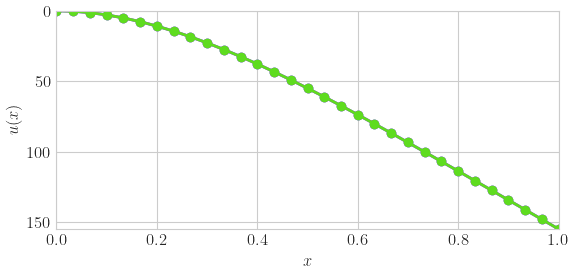

In [73]:
from matplotlib import pyplot
pyplot.style.use('../../../../qmcpy.mplstyle') #may need to be changed to find path to document in QMCSoftware folder
fig,ax = pyplot.subplots(figsize=(6,3))
ax.plot(x_values, solution,'-o')
ax.plot(x_values, data.comb_bound_low,'-o')
ax.plot(x_values, data.comb_bound_high,'-o')
ax.set_xlim([0,len(solution)-1]); ax.set_xlabel(r'$x$') #[0,1] -- L=31 internals
ax.set_ylim([max(solution), min(solution)]);  ax.set_ylabel(r'$u(x)$');

## Parallel Evaluation

QMCPy can automatically multi-threaded requests to the model by setting `parallel=p` where `p` is the number of processors used by [multiprocessing.pool.ThreadPool](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.ThreadPool). Setting `parallel=True` is equivalent to setting `paralle=os.cpu_count()`.

In [27]:
import os
print('Available CPUs: %d'%os.cpu_count())

Available CPUs: 8


In [81]:
integrand = qp.UMBridgeWrapper(distribution_mul,model,umbridge_config,parallel=8,tf_input_to_umbridge_input = lambda t: t)
start_time = time.time()
solution,data = qp.CubQMCNetG(integrand,abs_tol=10).integrate()
end_time = time.time()
print(end_time - start_time)
data

3.421820640563965


LDTransformData (AccumulateData Object)
    solution        [  0.      0.344   1.329 ... 140.952 147.811 154.672]
    comb_bound_low  [  0.      0.344   1.329 ... 140.951 147.811 154.671]
    comb_bound_high [  0.      0.344   1.329 ... 140.952 147.811 154.672]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(10)
    n               [1024. 1024. 1024. ... 1024. 1024. 1024.]
    time_integrate  3.422
CubQMCNetG (StoppingCriterion Object)
    abs_tol         10
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Gaussian (TrueMeasure Object)
    mean            [150. 150. 150. ... 150. 150. 150.]
    covariance      [[0.01  0.01  0.01  ... 0.002 0.002 0.001]
                    [0.01  0.01  0.01  ... 0.002 0.002 0.002]
                    [0.01  0.01  0.01  ... 0.002 0.002 0.002]
                    ...
                    [0.002 0.002 0.002 ... 0.01  0.01  0.01 ]
                    [0.002 0.0

## Shut Down Docker Image

In [239]:
!docker rm -f muqbp_new

muqbp_new


## Testbed

In [7]:
#from http://g2s3.com/labs/notebooks/EulerBernoulliLoads.html and GenerateObservations.py
priorVar = 10*10
priorLength = 0.5
priorNu = 3.0/2.0 # must take the form N+1/2 for zero or odd N (i.e., {0,1,3,5,...})

kern1 = ma.MaternKernel(1, 1.0, priorLength, priorNu)
kern2 = ma.ConstantKernel(1, priorVar)
kern = kern1 + kern2

dim =1
coDim = 1 # The dimension of the load field at a single point
mu = ma.ZeroMean(dim,coDim)

priorGP = ma.GaussianProcess(mu,kern)

plt.figure(figsize=(14,6))

numSamps = 3
for i in range(numSamps):
    samp = priorGP.Sample(x)
    plt.plot(x[0,:], samp[0,:], linewidth=2)
    
plt.xlabel('Position',fontsize=16)
plt.ylabel('Load',fontsize=16)
plt.show()

TypeError: Matern.__init__() got multiple values for argument 'length_scale'